# Imports

In [3]:
import numpy as np
import itertools
from typing import List, Dict
import time
import ast
import pandas
import matplotlib.pylab as plt
import random

In [4]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [5]:
def score_function(seq1, seq2, gap, match, mismatch):
    score = 0
    for x, y in zip(seq1, seq2):
        if x == y:
            score += match
        elif x == '-' or y == '-':
            score += gap
        else:
            score += mismatch
    return score

# First Algo

In [6]:
def update(grid, i, j, ismatch, gap, match, mismatch):
    left = grid[i, j - 1] + gap
    up = grid[i - 1, j] + gap
    dig = grid[i - 1, j - 1] + match if ismatch else grid[i - 1, j - 1] + mismatch
    grid[i, j] = max(left, up, dig)

In [7]:
def init(grid, i, j, gap):
    if i == 0 and j == 0:
        grid[i, j] = 0
    elif i == 0:
        grid[i, j] = grid[i, j-1] + gap
    elif j == 0:
        grid[i, j] = grid[i-1, j] + gap
    else:
        raise("error")

In [8]:
def nw(x, y, debug, gap=-2, match=1, mismatch=-1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [9]:
def algorithm1(seq1, seq2, debug, gap=-2, match=1, mismatch=-1):
    number_of_comp = 0
    if len(seq1) < len(seq2):
        temp = seq1
        seq1 = seq2
        seq2 = temp
    grid = np.zeros(
        (len(seq1)+1, len(seq2)+1)
    )
    if debug:
        print(grid)
        print(grid.shape)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            number_of_comp += 1
            if i == 0 or j == 0:
                init(grid, i, j, gap)
            else:
                ismatch = seq1[i-1] == seq2[j-1]
                update(grid, i, j, ismatch, gap, match, mismatch)
    if debug:
        print(grid)
        print(i, j)
    result1 = ""
    result2 = ""
    while i > 0 and j > 0:
        ismatch = seq1[i-1] == seq2[j-1]
        number_of_comp += 1
        if ismatch:
            i -= 1
            j -= 1
            result1 += seq1[i]
            result2 += seq2[j]
            if debug:
                print(result1[::-1])
                print(result2[::-1])
        else:
            left = grid[i, j - 1]
            up = grid[i - 1, j]
            dig = grid[i - 1, j - 1]
            values = [left, up, dig]
            max_value = max(values)
            for idx, value in enumerate(values):
                number_of_comp += 1
                if value == max_value:
                    if idx == 0:
                        number_of_comp += 1
                        j -= 1
                        result1 += "-"
                        result2 += seq2[j]
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
                    elif idx ==1:
                        number_of_comp += 2
                        i -= 1
                        result1 += seq1[i]
                        result2 += "-"
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
                    else:
                        number_of_comp += 2
                        i -= 1
                        j -= 1
                        result1 += seq1[i]
                        result2 += seq2[j]
                        if debug:
                            print(result1[::-1])
                            print(result2[::-1])
    if i == 1:
        number_of_comp += 1
        i -= 1
        result1 += seq1[i]
        result2 += "-"
    elif j == 1:
        number_of_comp += 2
        j -= 1
        result1 += "-"
        result2 += seq2[j]
    if debug:
        print(i, j, grid[i,j])
        print(result1[::-1])
        print(result2[::-1])
    return result1[::-1], result2[::-1], number_of_comp         

In [8]:
seq1 = "Mohammed"
seq2 = "hamed"

In [9]:
seq2 = "ATGCT"
seq1 = "AGCT"

In [10]:
seq1 = "DISTANCE"
seq2 = "EDIT"

In [11]:
algorithm1(seq2, seq1, debug=False)

('-DISTANCE', 'EDI-T----', 80)

# Analysis

In [21]:
def analysis(algo, sequences: List[str], hyperparameters_list: List[Dict[str, int]], debug: bool):
    plt.figure(figsize=(20,10))
    """
    Args:
        algorithm: function that accept two string sequences, a debug boolean, and hyperparameters dict
        sequences: list of strings, each string is a sequence that is going to be aligned against every other sequence
        hyperparameters_list: list of hyperparameters dicts
        debug: bool that decided wether or not to print debugging logs
    Returns:
        Dataframe of all the experiment results, and plots standrized theortical time complexity and real runtime.
    """
    data = list(itertools.combinations(sequences, r=2))
    results = []

    for data_point in data:
        seq1, seq2 = data_point
        n = len(seq1)
        m = len(seq2)
        outputs, runtimes, num_comp, edit_distances, scores  = [], [], [], [], []
        for i, hyperparameters in enumerate(hyperparameters_list):
            total_times = []
            for _ in range(15):
                start_time = time.time()
                output = algo(seq1, seq2, debug=debug, **hyperparameters)
                total_time = time.time() - start_time
                total_times.append(total_time)
            outputs.append(output[:2])
            num_comp.append(output[2])
            runtimes.append(np.mean(total_times))
            edit_distances.append(levenshteinDistance(*output[:2]))
            scores.append(score_function(*output[:2], **hyperparameters))
        r = {
            "outputs":outputs, "runtime":np.mean(runtimes),
            "number of comparsion": np.mean(num_comp),
            "edit distance": edit_distances,
            "score": scores,
            "input size": n*m,
            "input_size": f"{n}, {m}",
            "Avg O(m+n)" : m+n,
            "Worst O(nm)": n*m,
#             "parameter": hyperparameters_list
        }
        results.append(r)
    df = pandas.DataFrame(data=results, index=data)
    df_x = df[['runtime', 'Avg O(m+n)', 'Worst O(nm)', 'number of comparsion']]

    #standardize the values for each predictor variable
    df[['runtime', 'Avg O(m+n)', 'Worst O(nm)', 'number of comparsion']] = ((df_x-df_x.mean())/df_x.std()) + 2
#     df[['runtime', 'O(nm)']] = (df_x - df_x.min()) / (df_x.max() - df_x.min())
    x = df['input size']
    y1 = df['runtime']
    y2 = df['Worst O(nm)']
    y3 = df['number of comparsion']
    y4 = df['Avg O(m+n)']
    
    plt.plot(x, y1, '.b')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y1, 1))(np.unique(x)), '-b')
    
    plt.plot(x, y2, '.r')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), '-r')
    
    plt.plot(x, y3, '.g')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y3, 1))(np.unique(x)), '-g')
    
    plt.plot(x, y4, '.m')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y3, 1))(np.unique(x)), '-m')    
    
    plt.xlabel('input size', fontsize=18)
    plt.ylabel('normalized values', fontsize=18)
    plt.legend(['runtime', 'runtime', 'Avg O(m+n)', 'Worst O(nm)', 'Worst O(nm)', 'number of comparsion', 'number of comparsion'], loc='upper left')
    return df

### Fake Data for testing

In [25]:
fake_data = [''.join(random.choice(['A', 'G', 'C', 'T']) for _ in range(random.randint(20, 30))) for _ in range(20)]

In [26]:
fake_data[:4]

['AGAGTGGTTGCTAGGCCTATACATGT',
 'CTACGAGGTACTAAAAGCTCGGATACCGG',
 'TGGCTAGTAGAACTAGTCGGCGGC',
 'CAGCTTCCGAGAAACCACCACGCTGTTA']

### Experiment using the first algorithm

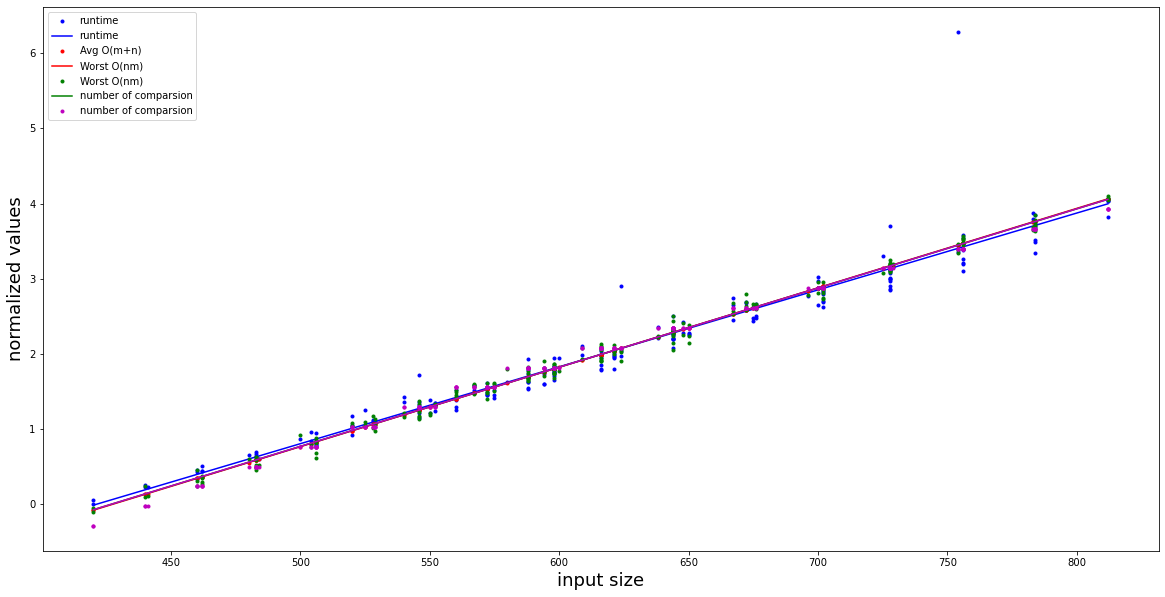

In [27]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results1 = analysis(
    algo=algorithm1,
    sequences=fake_data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [28]:
results1[:10]

,outputs,runtime,number of comparsion,edit distance,score,input size,input_size,Avg O(m+n),Worst O(nm)
"(AGAGTGGTTGCTAGGCCTATACATGT, CTACGAGGTACTAAAAGCTCGGATACCGG)","[(CTACGAGGTA-CTAAAAGCTCGGATACCGG-, AGA-GTGGTTG...",6.286517,3.341967,"[15, 14, 15]","[-6, -2, 1]",754,"26, 29",3.399684,3.448571
"(AGAGTGGTTGCTAGGCCTATACATGT, TGGCTAGTAGAACTAGTCGGCGGC)","[(TGGTT-GCTAGGCCTA-TACAT-GT-, TGGCTAG-TAGAACTA...",2.896177,1.907998,"[12, 12, 12]","[-4, -4, 2]",624,"26, 24",2.079227,2.072746
"(AGAGTGGTTGCTAGGCCTATACATGT, CAGCTTCCGAGAAACCACCACGCTGTTA)","[(C-AGC--TTCCGAGAAACC-ACCACGC-TGTTA, AGAGTGGTT...",2.967513,3.180170,"[18, 17, 17]","[-15, -9, -2]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, TTTTCGAGAAGTCCCGAAGAGAACTAAT)","[(TTTTCGAGAAGTCCCGAAGAG-A-ACTAA-T, A----GAGTGG...",3.012492,3.180170,"[18, 17, 15]","[-15, -11, -4]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, ACCCTAGATACACCTCTTAGAG)","[(AGAGTGGTTGCTAGGC-CTATACATGT, ACCCTAGATAC-AC-...",1.529133,1.552678,"[14, 14, 15]","[-7, -9, -4]",572,"26, 22",1.551045,1.522416
"(AGAGTGGTTGCTAGGCCTATACATGT, TAGCAGAATGAGCATCACCAGCCCAG)","[(-AG-AGTGGTT-GCTA-GG-CCTATA-CATGT, TAGCAGAATG...",2.665286,2.666225,"[17, 18, 19]","[-20, -10, -7]",676,"26, 26",2.607410,2.623076
"(AGAGTGGTTGCTAGGCCTATACATGT, CCCAGTTGCGAAACTAAGAGCAAGGCTT)","[(CCCAGTTGCGAAACTAAGAGCA-AGGC-T-T, AG-AG-TG-GT...",3.110596,3.142100,"[16, 15, 17]","[-9, -3, -2]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, TCATCGAGAAGGCTGTCACCTAA)","[(AGAGTGGTTGCTAGGCCTAT-ACATGT, TCA-TCGA-GA-AGG...",1.759018,1.793788,"[14, 15, 14]","[-6, -5, -1]",598,"26, 23",1.815136,1.797581
"(AGAGTGGTTGCTAGGCCTATACATGT, TCAAGAATGCTCTTCTACCCAT)","[(AGAGTGGTTGCTAGGCCTATACATGT, TCAA-GAATGCTCTT-...",1.449607,1.479710,"[14, 12, 12]","[-6, 0, 3]",572,"26, 22",1.551045,1.522416
"(AGAGTGGTTGCTAGGCCTATACATGT, TCGCATACATGCGCTACGGAAGAGT)","[(A-G-AGTGGTTGCTAGGCCTATACATGT, TCGCA-TACATGCG...",2.244914,2.383872,"[16, 17, 16]","[-9, -9, -1]",650,"26, 25",2.343319,2.347911


### Read Real Data (TODO)

In [ ]:
real_data = # TODO

In [ ]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results = analysis(
    algo=algorithm1,
    sequences=real_data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [ ]:
results[:10]

### Experiment using the second algoritm (TODO)

In [15]:
from algo2 import FOGSAA as algorithm2

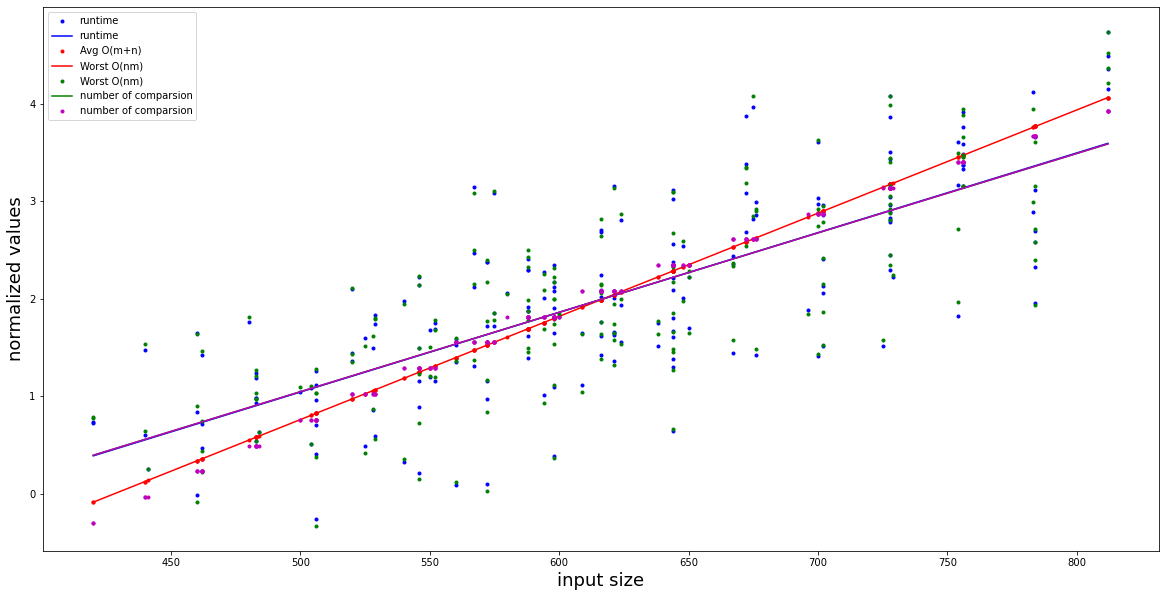

In [29]:
hyperparameters_list = [
    {"gap": -2, "match": 1, "mismatch": -1},
    {"gap": -1, "match": 1, "mismatch": -2},
    {"gap": -1, "match": 1, "mismatch": -1},
]
results2 = analysis(
    algo=algorithm2,
    sequences=fake_data,
    hyperparameters_list=hyperparameters_list, debug=False
)

In [30]:
results2[:10]

,outputs,runtime,number of comparsion,edit distance,score,input size,input_size,Avg O(m+n),Worst O(nm)
"(AGAGTGGTTGCTAGGCCTATACATGT, CTACGAGGTACTAAAAGCTCGGATACCGG)","[(----AGAGTGGTTGCTAGGCCTATACATGT, CTACGAGGTACT...",3.161918,2.709913,"[18, 17, 16]","[-17, -25, -8]",754,"26, 29",3.399684,3.448571
"(AGAGTGGTTGCTAGGCCTATACATGT, TGGCTAGTAGAACTAGTCGGCGGC)","[(AGAGTGGTTGCTAGGCCTA-T-ACATGT, ---TGGCTAG-TAG...",2.805357,2.871961,"[16, 18, 16]","[-12, -29, -4]",624,"26, 24",2.079227,2.072746
"(AGAGTGGTTGCTAGGCCTATACATGT, CAGCTTCCGAGAAACCACCACGCTGTTA)","[(AGAGTGGTTGCTAG-GCCTA-TAC-ATGT--, --CAG-CTTCC...",3.434271,3.402773,"[18, 24, 20]","[-15, -24, -9]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, TTTTCGAGAAGTCCCGAAGAGAACTAAT)","[(----AGAGTGGTTGCTAGGCCTATACATGT, TTTTCGAGAAGT...",2.804205,2.805999,"[18, 26, 22]","[-12, -27, -11]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, ACCCTAGATACACCTCTTAGAG)","[(AGAGTGGTTGCTAGGCCTATACATGT, ACCCTAGATAC-ACCT...",2.372550,2.172349,"[14, 18, 14]","[-6, -18, -1]",572,"26, 22",1.551045,1.522416
"(AGAGTGGTTGCTAGGCCTATACATGT, TAGCAGAATGAGCATCACCAGCCCAG)","[(--AGAGTGGTTGCTAGGCCTATACATGT, TAGCAGAATGAGC-...",2.992142,2.894814,"[18, 20, 20]","[-14, -25, -11]",676,"26, 26",2.607410,2.623076
"(AGAGTGGTTGCTAGGCCTATACATGT, CCCAGTTGCGAAACTAAGAGCAAGGCTT)","[(---AGA-GTGGTTGCTAGGCCTATACATGT, CCCAGTTGCGAA...",2.447493,2.447104,"[18, 20, 18]","[-14, -27, -7]",728,"26, 28",3.135593,3.173406
"(AGAGTGGTTGCTAGGCCTATACATGT, TCATCGAGAAGGCTGTCACCTAA)","[(AGAGTGGTTGCTAGGCCTAT-ACATGT, TCA-TCG--A-GAAG...",1.645250,1.537659,"[16, 20, 16]","[-10, -19, -5]",598,"26, 23",1.815136,1.797581
"(AGAGTGGTTGCTAGGCCTATACATGT, TCAAGAATGCTCTTCTACCCAT)","[(AGAGTGGTTGCTAGGCCTATACATGT, TCA-AGAATGCT---C...",0.966492,0.835450,"[14, 16, 17]","[-6, -3, -9]",572,"26, 22",1.551045,1.522416
"(AGAGTGGTTGCTAGGCCTATACATGT, TCGCATACATGCGCTACGGAAGAGT)","[(-AGAGTGGTTGCTAGGCCTATACATGT, TCGCATACATGCGCT...",1.704379,1.647250,"[16, 21, 20]","[-8, -24, -14]",650,"26, 25",2.343319,2.347911
